In [1]:
!pip install pyro-ppl

In [1]:
import pyro 
import torch 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [9]:
import pyro.distributions as dist
from torch.nn import Embedding
import ast
from tqdm import tqdm
from collections import Counter 
import itertools

In [3]:
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive


In [6]:
dat = pd.read_csv('./data/cleaned_documents_imdb.csv',converters = {"text":ast.literal_eval})

In [7]:
E = 100 # size of embedding


In [20]:
words= list(itertools.chain.from_iterable(dat.text))
uni_freq = Counter(words)
words = set(words)
word2idx = {word:idx for idx, word in enumerate(words)}
idx2word = {idx:word for idx, word in enumerate(words)}
W = len(set(words))

In [22]:
for each in uni_freq:
    uni_freq[each] = uni_freq[each]**0.75
deno = sum(uni_freq.values())
for each in uni_freq:
    uni_freq[each] = uni_freq[each]/deno


### For each document in the corpus, we get x_n^+ and x_n^- by looking at context window and negative sampling. 
Ref : https://arxiv.org/pdf/1711.03946.pdf

In [23]:
# Hard coding context window size to 3.
c = 4
neg_samples = 2*c
def get_pos_neg_sample(dat):
    x_plus = []
    x_neg = []
    uni_keys = list(uni_freq.keys())
    uni_values = list(uni_freq.values())
    for each in dat.text:
        x_plus_n = []
        x_neg_n = []
        sentence = each
        random_sample = np.random.choice(uni_keys, len(sentence)*neg_samples, p = uni_values)
        r_i = 0
        for idx, token in enumerate(sentence):
            context = sentence[max(idx-c,0):min(idx+c+1, len(sentence))]
            context.remove(token)
            for every in context:
                x_plus_n.append((word2idx[token], word2idx[every]))
                
            for sample in random_sample[r_i:r_i+len(context)]:
                x_neg_n.append((word2idx[token], word2idx[sample]))
            r_i+=len(context)
            
        x_plus.append(x_plus_n)
        x_neg.append(x_neg_n)
    return x_plus, x_neg

In [24]:
x_plus, x_neg = get_pos_neg_sample(dat)

# Stage 1 : Update U,V using sgd


In [25]:

def get_loss(U,V, d_i, X_plus, X_neg):
    return -torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 1,E) ,
                                                            (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0], E, 1))))) - torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 1, E) ,
                                                            (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0], E, 1)))))

In [27]:
lamb = 1
phi = 1
annealed_rate = 0.001
alpha = 0.9999
n_iter = 100
loss = []
U = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
V = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
U.requires_grad=True
V.requires_grad=True
optimizer = torch.optim.SGD([U, V], lr = 0.01)
len_ = len(x_plus)
for it in range(5):
    for n in range(len_):
        for g in optimizer.param_groups:
            g['lr'] *= alpha
        d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)
        opti = torch.optim.Adam([d_i], lr = 1)
        X_plus = torch.tensor(x_plus[n])
        X_neg = torch.tensor(x_neg[n])
        #SGD for d_i
        for iterat in range(n_iter):
            # Loss function
            opti.zero_grad()
            logProb = get_loss(U,V, d_i, X_plus, X_neg)
            logProb.backward()
            opti.step()
            # if iterat==0 or iterat==n_iter-1:
            #   print("Iter : {}, logprob : {}".format(iterat, logProb))
        optimizer.zero_grad()
        log_loss = get_loss(U,V, d_i, X_plus, X_neg)
        log_loss.backward()
        optimizer.step()
        loss.append(log_loss)
        if n%100==0:
            print("Iteration : {}, logProb : {}".format(n+1, logProb))


Iteration : 1, logProb : 8869.95703125
Iteration : 101, logProb : 3521.80517578125
Iteration : 201, logProb : 2307.836181640625
Iteration : 301, logProb : 2827.96826171875
Iteration : 401, logProb : 10664.88671875
Iteration : 501, logProb : 3685.301025390625
Iteration : 601, logProb : 2143.28271484375
Iteration : 701, logProb : 2324.98486328125
Iteration : 801, logProb : 2134.4931640625
Iteration : 901, logProb : 1626.3974609375
Iteration : 1001, logProb : 1836.1510009765625
Iteration : 1101, logProb : 4073.9501953125
Iteration : 1201, logProb : 1756.0419921875
Iteration : 1301, logProb : 615.437255859375
Iteration : 1401, logProb : 822.646240234375
Iteration : 1501, logProb : 1738.0552978515625
Iteration : 1601, logProb : 2344.734375
Iteration : 1701, logProb : 5920.548828125
Iteration : 1801, logProb : 5801.314453125
Iteration : 1901, logProb : 1601.67333984375
Iteration : 2001, logProb : nan
Iteration : 2101, logProb : nan
Iteration : 2201, logProb : nan
Iteration : 2301, logProb : 

KeyboardInterrupt: 

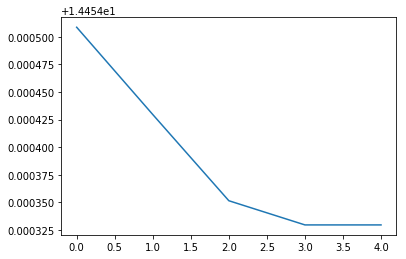

In [23]:
iterationLoss = []
for i in range(5):
    count = 0
    for j in range(len_):
        count += loss[i+j]
    iterationLoss.append(count)
plt.plot(np.log(np.array(iterationLoss)))

In [0]:
# lamb = 0.01
# phi = 0.01
# annealed_rate = 0.001
# alpha = 0.89
# n_iter = 100
# loss = []
# U = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
# V = torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample()
# U.requires_grad=True
# V.requires_grad=True
# for it in range(100):
#   for n in range(1):
#       annealed_rate = annealed_rate * alpha
#       d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)
#       X_plus = torch.tensor(x_plus[0])
#       X_neg = torch.tensor(x_neg[0])
#       #SGD for d_i
#       for iterat in range(n_iter):
#           # Loss function
#           logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 
#                                                                                     1,
#                                                                                     E) ,
#                                                                 (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],
#                                                                                           E,
#                                                                                           1)))))
#           logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 
#                                                                                     1,
#                                                                                     E) ,
#                                                                 (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0],
#                                                                                           E,
#                                                                                           1)))))


#           d_i.retain_grad()
#           logProb.backward()
#           temp = d_i.grad
#           d_i = d_i+temp
#           # if iterat==0 or iterat==n_iter-1:
#           #   print("Iter : {}, logprob : {}, gradient : {}".format(iterat, logProb, torch.mean(temp)))
#       # SGD for U_i, V_j
      
#       logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 
#                                                                                 1,
#                                                                                 E) ,
#                                                             (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],
#                                                                                       E,
#                                                                                       1)))))
#       logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 
#                                                                                 1,
#                                                                                 E) ,
#                                                             (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0],
#                                                                                       E,
#                                                                                       1)))))

#       loss.append(logProb)
#       U.retain_grad()
#       V.retain_grad()
#       logProb.backward()
#       if n%100==0:
#           print("Iteration : {}, logProb : {}, it  : {}".format(n+1, logProb, it))
#       U = U + annealed_rate * U.grad
#       V = V + annealed_rate * V.grad

In [0]:
import pickle 


In [19]:
torch.save(U, "U")

In [20]:
torch.save(V,"V")

# Stage 2 : Fix U,V and update d (doc vector) using SVI 

In [20]:
!ls

cleaned_documents.csv  sample_data  U  V


In [36]:
def model(X_full, Y_full, U, V):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 100
    with pyro.plate('K', len(X_full)):
        d_i = pyro.sample("d_i", dist.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)))
    with pyro.plate('observations', len(X_full), 1) as idx:
      X = torch.tensor(X_full[idx])
      Y = Y_full[idx]
      logit = torch.bmm(U[X[:,0]].view(U[X[:,0]].shape[0], 1, E) ,(V[X[:,1]]+d_i[idx]).view((V[X[:,1]]+d_i[idx]).shape[0],E,1))
      target = pyro.sample('obs', dist.Bernoulli(logits=logit), obs=Y)
    return d_i

In [37]:
guide_di = AutoDiagonalNormal(model)
optim = Adam({"lr":0.01})
svi_di = SVI(model,guide_di,optim,loss=Trace_ELBO())

In [39]:
def train_d_i(x_plus,x_neg, U, V):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 1000
    losses = []
    pyro.clear_param_store()
    X = []
    Y = []
    for idx,_ in enumerate(x_plus):
        X_plus = torch.tensor(x_plus[idx])
        X_neg = torch.tensor(x_neg[idx])
        X_n = torch.cat((X_plus,X_neg))
        Y_n = torch.tensor([float(1) for each in range(len(X_plus))] + [float(0) for each in range(len(X_neg))])
        X.append(X_n)
        Y.append(Y_n)
    for i in range(n_iter):
        loss = svi_di.step(X, Y, U, V)
        losses.append(loss)
    return losses
losses = train_d_i(x_plus,x_neg, U, V)

/home/chinmay41018/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [61]:
a,b = U[word2idx["reporter"]], U[word2idx["media"]]

In [62]:
a = a.data.numpy()
b = b.data.numpy()

In [63]:
np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.047921818

In [40]:
pyro.get_param_store().keys()

dict_keys(['auto_loc', 'auto_scale'])

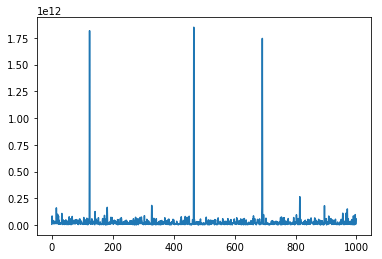

In [41]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [42]:
U.shape, V.shape

(torch.Size([15673, 100]), torch.Size([15673, 100]))

In [43]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_stats[site_name] = np.mean(marginal[:, i], axis = 0)
    return site_stats

def wrapped_model(X_full, Y_full, U, V):
    pyro.sample("prediction", dist.Delta(model(X_full, Y_full, U, V)))

X_full = x_plus
Y_full = x_neg

posterior = svi_di.run(X_full, Y_full, U, V)

# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(X_full, Y_full, U, V)
post_summary = summary(post_pred, sites= ['d_i'])
d_i = post_summary["d_i"]


In [31]:
d_i.shape

(2225, 100)

In [32]:
np.dot(d_i[0],d_i[1])/(np.linalg.norm(d_i[0]) * np.linalg.norm(d_i[1]))

0.7021808

In [33]:
# logProb = torch.Value(0,requires_gradient=True)


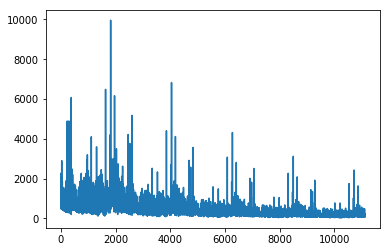

In [34]:
plt.plot(loss)

In [35]:
torch.save(d_i,"di")